In [17]:
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [18]:
# Initialize the Binance client
api_key = 'your_api_key'
api_secret = 'your_api_secret'
client = Client(api_key, api_secret)

# Get historical data for BTCUSDT
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2010", "28 Feb, 2025")

# Create a DataFrame
df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

btc = df[['open', 'close', 'volume']].copy()
print(btc.head())

                     open          close         volume
timestamp                                              
2017-08-17  4261.48000000  4285.08000000   795.15037700
2017-08-18  4285.08000000  4108.37000000  1199.88826400
2017-08-19  4108.37000000  4139.98000000   381.30976300
2017-08-20  4120.98000000  4086.29000000   467.08302200
2017-08-21  4069.13000000  4016.00000000   691.74306000


In [19]:
for _ in range(1, 101):
    btc[f'close_{_}'] = btc['close'].shift(_)
    btc[f'volume_{_}'] = btc['volume'].shift(_)

btc['day'] = range(1, len(btc) + 1)

btc['result'] = (btc['close'].astype(float) / btc['open'].astype(float)).apply(lambda x: 1 if x > 1.002 else 0)
#btc['result'] = (btc['close'].astype(float) / btc['open'].astype(float)).apply(lambda x: 1 if x < 0.998 else 0)

print(btc.head())

                     open          close         volume        close_1  \
timestamp                                                                
2017-08-17  4261.48000000  4285.08000000   795.15037700           None   
2017-08-18  4285.08000000  4108.37000000  1199.88826400  4285.08000000   
2017-08-19  4108.37000000  4139.98000000   381.30976300  4108.37000000   
2017-08-20  4120.98000000  4086.29000000   467.08302200  4139.98000000   
2017-08-21  4069.13000000  4016.00000000   691.74306000  4086.29000000   

                 volume_1        close_2       volume_2        close_3  \
timestamp                                                                
2017-08-17           None           None           None           None   
2017-08-18   795.15037700           None           None           None   
2017-08-19  1199.88826400  4285.08000000   795.15037700           None   
2017-08-20   381.30976300  4108.37000000  1199.88826400  4285.08000000   
2017-08-21   467.08302200  4139.98000

C:\Users\isaac\AppData\Local\Temp\ipykernel_6908\3297295708.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  btc[f'volume_{_}'] = btc['volume'].shift(_)
C:\Users\isaac\AppData\Local\Temp\ipykernel_6908\3297295708.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  btc[f'close_{_}'] = btc['close'].shift(_)
C:\Users\isaac\AppData\Local\Temp\ipykernel_6908\3297295708.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

In [20]:
btc_cleaned = btc.dropna()
print(btc_cleaned.head(-10))

                      open           close          volume         close_1  \
timestamp                                                                    
2017-11-25   8138.99000000   8700.01000000   4292.62368200   8138.00000000   
2017-11-26   8700.04000000   9128.02000000   4147.38023700   8700.01000000   
2017-11-27   9128.00000000   9650.00000000   4521.62570700   9128.02000000   
2017-11-28   9650.00000000   9896.80000000   4917.21098500   9650.00000000   
2017-11-29   9896.79000000   9687.88000000  13352.53871500   9896.80000000   
...                    ...             ...             ...             ...   
2025-02-14  96608.13000000  97500.48000000  18173.02646000  96608.14000000   
2025-02-15  97500.47000000  97569.66000000   7349.37683000  97500.48000000   
2025-02-16  97569.67000000  96118.12000000   8191.42490000  97569.66000000   
2025-02-17  96118.12000000  95780.00000000  16492.04510000  96118.12000000   
2025-02-18  95780.01000000  95671.74000000  23368.19471000  9578

In [21]:
# Calculate the indices for splitting the data
train_size = int(len(btc) * 0.6)
validate_size = int(len(btc) * 0.2)

# Split the data
train = btc[:train_size]
validate = btc[train_size:train_size + validate_size]
test = btc[train_size + validate_size:]

# Define the columns for train_x and train_y
x_columns = [f'close_{i}' for i in range(1, 101)] + ['day']
y_column = 'result'

# Separate train_x and train_y
train_x = train[x_columns]
train_y = train[y_column]

# Separate validate_x and validate_y
validate_x = validate[x_columns]
validate_y = validate[y_column]

# Separate test_x and test_y
test_x = test[x_columns]
test_y = test[y_column]

train_x.info()
train_y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1651 entries, 2017-08-17 to 2022-02-22
Columns: 101 entries, close_1 to day
dtypes: int64(1), object(100)
memory usage: 1.3+ MB
<class 'pandas.core.series.Series'>
DatetimeIndex: 1651 entries, 2017-08-17 to 2022-02-22
Series name: result
Non-Null Count  Dtype
--------------  -----
1651 non-null   int64
dtypes: int64(1)
memory usage: 25.8 KB


In [22]:


# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
train_x_imputed = imputer.fit_transform(train_x)
validate_x_imputed = imputer.transform(validate_x)

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Fit the model
log_reg.fit(train_x_imputed, train_y)

# Predict on the training data
train_y_pred = log_reg.predict(train_x_imputed)

# Calculate the accuracy
accuracy = accuracy_score(train_y, train_y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.5838885523924894


c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn.fit(train_x_imputed, train_y)

# Predict on the training data
train_y_pred_knn = knn.predict(train_x_imputed)

# Calculate the accuracy
accuracy_knn = accuracy_score(train_y, train_y_pred_knn)
print(f'KNN Accuracy: {accuracy_knn}')

KNN Accuracy: 0.6674742580254391


In [24]:
# Initialize the Random Forest Classifier with reduced number of estimators, limited max depth, and class weights
rf_classifier = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=42)

# Fit the model
rf_classifier.fit(train_x, train_y)

# Predict on the training data
train_y_pred_rf = rf_classifier.predict(train_x)

# Calculate the accuracy
accuracy = accuracy_score(train_y, train_y_pred_rf)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6868564506359782


In [25]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model
dt_classifier.fit(train_x, train_y)

# Predict on the training data
train_y_pred_dt = dt_classifier.predict(train_x_imputed)

# Calculate the accuracy
accuracy_dt = accuracy_score(train_y, train_y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt}')

# Predict on the validation data
validate_y_pred_dt = dt_classifier.predict(validate_x)

# Calculate the accuracy on the validation data
accuracy_validate_dt = accuracy_score(validate_y, validate_y_pred_dt)
print(f'Decision Tree Validation Accuracy: {accuracy_validate_dt}')

Decision Tree Accuracy: 0.9836462749848577
Decision Tree Validation Accuracy: 0.4218181818181818


c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [26]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
gb_classifier = GradientBoostingClassifier(random_state=42)

# Fit the model
gb_classifier.fit(train_x_imputed, train_y)

# Predict on the training data
train_y_pred_gb = gb_classifier.predict(train_x_imputed)

# Calculate the accuracy on the training data
accuracy_gb_train = accuracy_score(train_y, train_y_pred_gb)
print(f'Gradient Boosting Training Accuracy: {accuracy_gb_train}')

# Predict on the validation data
validate_y_pred_gb = gb_classifier.predict(validate_x_imputed)

# Calculate the accuracy on the validation data
accuracy_gb_validate = accuracy_score(validate_y, validate_y_pred_gb)
print(f'Gradient Boosting Validation Accuracy: {accuracy_gb_validate}')

Gradient Boosting Training Accuracy: 0.7970926711084192
Gradient Boosting Validation Accuracy: 0.41454545454545455


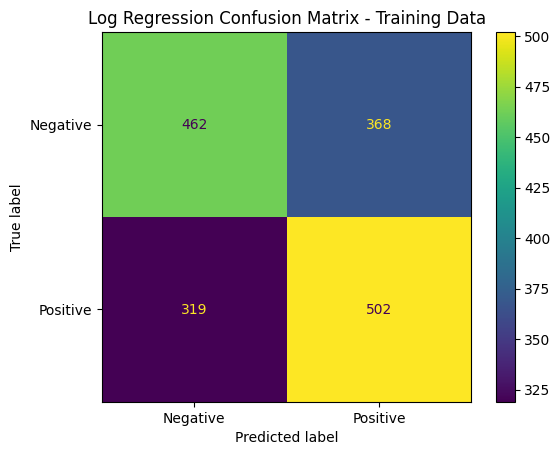

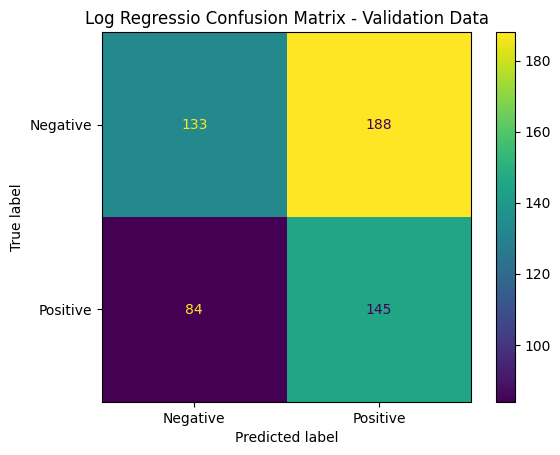

In [27]:
# Predict on the training data
train_y_pred_rf = log_reg.predict(train_x_imputed)

# Generate the confusion matrix for training data
conf_matrix_train = confusion_matrix(train_y, train_y_pred_rf)

# Display the confusion matrix with labels for training data
disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=['Negative', 'Positive'])
disp_train.plot()
plt.title('Log Regression Confusion Matrix - Training Data')
plt.show()

# Predict on the validation data
validate_x_imputed = imputer.fit_transform(validate_x)
validate_y_pred_rf = log_reg.predict(validate_x_imputed)

# Generate the confusion matrix for validation data
conf_matrix_validate = confusion_matrix(validate_y, validate_y_pred_rf)

# Display the confusion matrix with labels for validation data
disp_validate = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_validate, display_labels=['Negative', 'Positive'])
disp_validate.plot()
plt.title('Log Regressio Confusion Matrix - Validation Data')
plt.show()

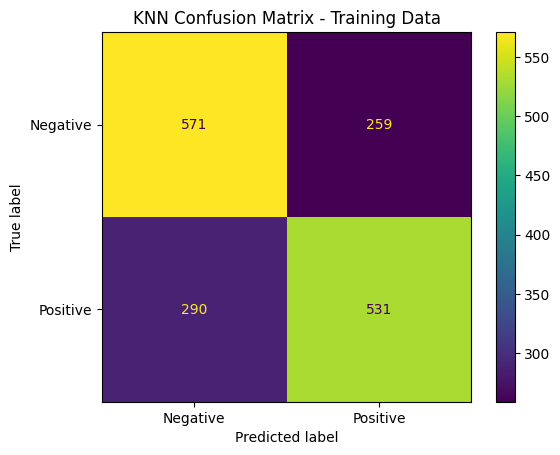

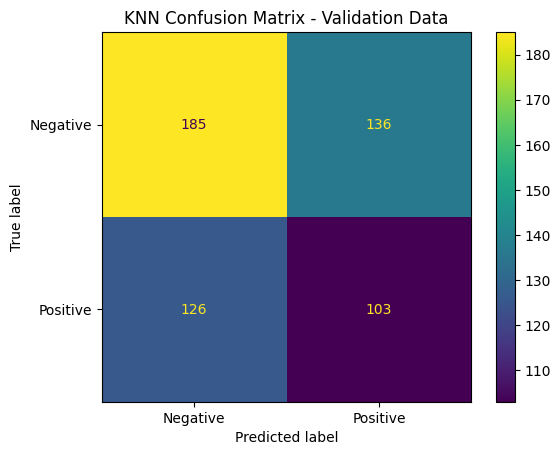

In [28]:
# Predict on the training data
train_y_pred_rf = knn.predict(train_x_imputed)

# Generate the confusion matrix for training data
conf_matrix_train = confusion_matrix(train_y, train_y_pred_rf)

# Display the confusion matrix with labels for training data
disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=['Negative', 'Positive'])
disp_train.plot()
plt.title('KNN Confusion Matrix - Training Data')
plt.show()

# Predict on the validation data
validate_x_imputed = imputer.fit_transform(validate_x)
validate_y_pred_rf = knn.predict(validate_x_imputed)

# Generate the confusion matrix for validation data
conf_matrix_validate = confusion_matrix(validate_y, validate_y_pred_rf)

# Display the confusion matrix with labels for validation data
disp_validate = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_validate, display_labels=['Negative', 'Positive'])
disp_validate.plot()
plt.title('KNN Confusion Matrix - Validation Data')
plt.show()

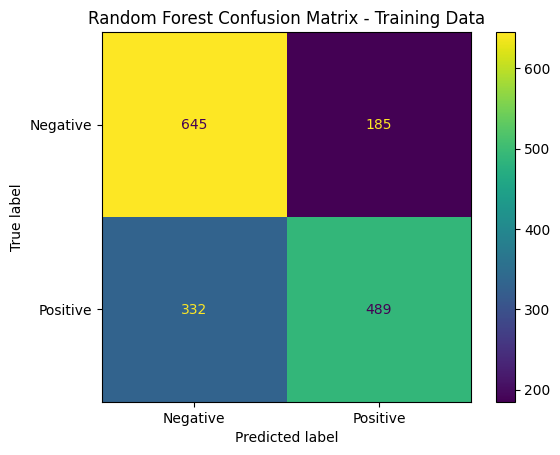

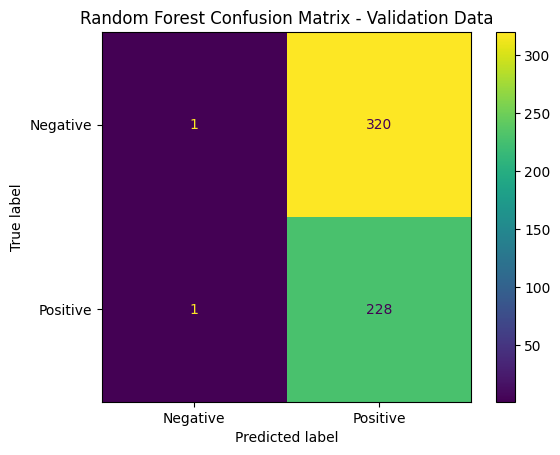

In [29]:
# Predict on the training data
train_y_pred_rf = rf_classifier.predict(train_x)

# Generate the confusion matrix for training data
conf_matrix_train = confusion_matrix(train_y, train_y_pred_rf)

# Display the confusion matrix with labels for training data
disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=['Negative', 'Positive'])
disp_train.plot()
plt.title('Random Forest Confusion Matrix - Training Data')
plt.show()

# Predict on the validation data
validate_y_pred_rf = rf_classifier.predict(validate_x)

# Generate the confusion matrix for validation data
conf_matrix_validate = confusion_matrix(validate_y, validate_y_pred_rf)

# Display the confusion matrix with labels for validation data
disp_validate = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_validate, display_labels=['Negative', 'Positive'])
disp_validate.plot()
plt.title('Random Forest Confusion Matrix - Validation Data')
plt.show()

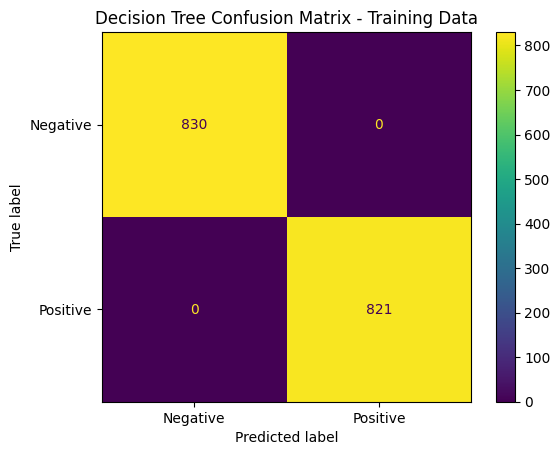

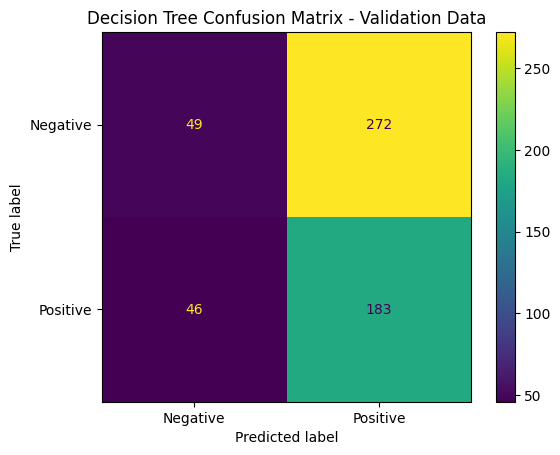

In [30]:
# Predict on the training data
train_y_pred_rf = dt_classifier.predict(train_x)

# Generate the confusion matrix for training data
conf_matrix_train = confusion_matrix(train_y, train_y_pred_rf)

# Display the confusion matrix with labels for training data
disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=['Negative', 'Positive'])
disp_train.plot()
plt.title('Decision Tree Confusion Matrix - Training Data')
plt.show()

# Predict on the validation data
validate_y_pred_rf = dt_classifier.predict(validate_x)

# Generate the confusion matrix for validation data
conf_matrix_validate = confusion_matrix(validate_y, validate_y_pred_rf)

# Display the confusion matrix with labels for validation data
disp_validate = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_validate, display_labels=['Negative', 'Positive'])
disp_validate.plot()
plt.title('Decision Tree Confusion Matrix - Validation Data')
plt.show()

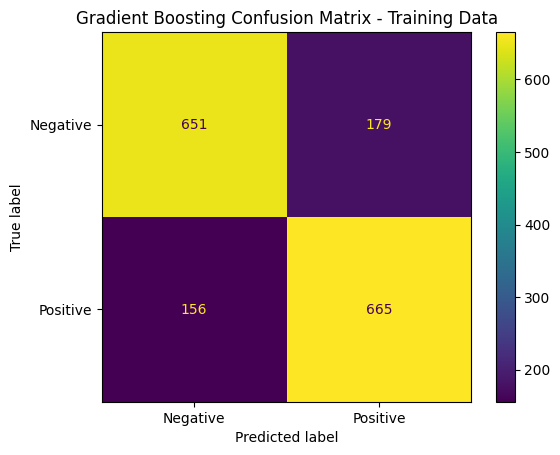

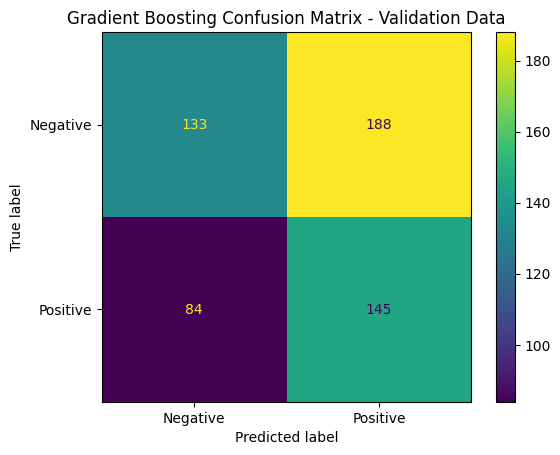

In [31]:
# Predict on the training data
train_y_pred_rf = gb_classifier.predict(train_x_imputed)

# Generate the confusion matrix for training data
conf_matrix_train = confusion_matrix(train_y, train_y_pred_rf)

# Display the confusion matrix with labels for training data
disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=['Negative', 'Positive'])
disp_train.plot()
plt.title('Gradient Boosting Confusion Matrix - Training Data')
plt.show()

# Predict on the validation data
validate_x_imputed = imputer.fit_transform(validate_x)
validate_y_pred_rf = log_reg.predict(validate_x_imputed)

# Generate the confusion matrix for validation data
conf_matrix_validate = confusion_matrix(validate_y, validate_y_pred_rf)

# Display the confusion matrix with labels for validation data
disp_validate = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_validate, display_labels=['Negative', 'Positive'])
disp_validate.plot()
plt.title('Gradient Boosting Confusion Matrix - Validation Data')
plt.show()